# DenseNet + Unet++

1) load a data for a test
2) update a loop for test
3) for each epoch display a training loss , validation loss and test loss + ssim value also

# Data Loading

## Train

In [4]:
X_train_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismic_w_noise_vol_42487393.npy'
y_train_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismicCubes_RFC_fullstack_2024.42487393.npy'

## Test

In [5]:
X_test_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-test-data/2024-06-10_0d6402b1/seismic_w_noise_vol_44319345.npy'
y_test_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487919/seismicCubes_RFC_fullstack_2024.42487919.npy'

## Valid

In [6]:
X_valid_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42502775/seismic_w_noise_vol_42502775.npy'
y_valid_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42502775/seismicCubes_RFC_fullstack_2024.42502775.npy'

In [7]:
shape = (1259,300,300)
# load the data
# make the data in 2d section
# make the train set and test set
# print the image also

In [8]:
import os
import pandas as pd
import numpy as np
from torchvision.io import read_image
from torch.utils.data import Dataset,DataLoader
import torch
# 2 files
# 1259*300*300 ---> 1259*300 in 300 images
# x,y load
# x,y sub sample
# pair
# return
class volDataset(Dataset):
    def __init__(self, x_slices, y_slices, transform=None):
        """
        x_slices: List of noisy seismic slices (each of shape 1259x300)
        y_slices: List of clean seismic slices (each of shape 1259x300)
        """
        self.x_slices = x_slices
        self.y_slices = y_slices
        self.transform = transform

    def __len__(self):
        return len(self.x_slices)

    def __getitem__(self, idx):
        """Returns one slice (1, 1259, 300)"""
        x_slice = torch.tensor(self.x_slices[idx], dtype=torch.float32).unsqueeze(0)  # (1, 1259, 300)
        y_slice = torch.tensor(self.y_slices[idx], dtype=torch.float32).unsqueeze(0)  # (1, 1259, 300)

        if self.transform:
            x_slice = self.transform(x_slice)
            y_slice = self.transform(y_slice)

        return x_slice, y_slice

In [9]:
from sklearn.model_selection import train_test_split
# Convert volume to 2D slices
# Load seismic volumes
X_volume = np.load('/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismic_w_noise_vol_42487393.npy',allow_pickle=True)  # (1259, 300, 300)
y_volume = np.load('/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismicCubes_RFC_fullstack_2024.42487393.npy',allow_pickle=True)  # (1259, 300, 300)

X_volume_t = np.load(X_test_path,allow_pickle=True)
y_volume_t = np.load(y_test_path,allow_pickle=True)

X_volume_v = np.load(X_valid_path,allow_pickle=True)
y_volume_v = np.load(y_valid_path,allow_pickle=True)
# Convert volume to 2D slices

X_slices = [X_volume[:, :, i] for i in range(X_volume.shape[2])]  # List of 300 slices
y_slices = [y_volume[:, :, i] for i in range(y_volume.shape[2])]  # List of 300 slices

X_slices_t = [X_volume_t[:, :, i] for i in range(X_volume_t.shape[2])]
y_slices_t = [y_volume_t[:, :, i] for i in range(y_volume_t.shape[2])]

X_slices_v = [X_volume_v[:, :, i] for i in range(X_volume_v.shape[2])]
y_slices_v = [y_volume_v[:, :, i] for i in range(y_volume_v.shape[2])]

# Create datasets
train_dataset = volDataset(X_slices, y_slices)
valid_dataset = volDataset(X_slices_v,y_slices_v)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(valid_dataset,batch_size=8, shuffle=False)

# Check batch shapes
for x_batch, y_batch in train_loader:
    print("Train Batch Shape:", x_batch.shape, y_batch.shape)  # Expected: (8, 1, 1259, 300)
    break
for x_batch, y_batch in val_loader:
    print("valid Batch Shape:", x_batch.shape, y_batch.shape)  # Expected: (8, 1, 1259, 300)
    break

Train Batch Shape: torch.Size([8, 1, 1259, 300]) torch.Size([8, 1, 1259, 300])
valid Batch Shape: torch.Size([8, 1, 1259, 300]) torch.Size([8, 1, 1259, 300])


# Model

In [10]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
class Crop2d(nn.Module):
    def __init__(self, left=10, right=10, top=21, bottom=0):
        super(Crop2d, self).__init__()
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom

    def forward(self, x):
        return x[:, :, self.top:x.shape[2] - self.bottom, self.left:x.shape[3] - self.right]

In [12]:
import timm
from segmentation_models_pytorch.decoders.unetplusplus import UnetPlusPlus

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import DenseNet161_Weights


class Crop2d(nn.Module):
    """Crops (left, right, top, bottom) from a 4D tensor (N, C, H, W)."""
    def __init__(self, left, right, top, bottom):
        super().__init__()
        self.left, self.right = left, right
        self.top, self.bottom = top, bottom

    def forward(self, x):
        return x[..., self.top:x.shape[2]-self.bottom, self.left:x.shape[3]-self.right]


class UpBlock(nn.Module):
    """Upsampling block with ConvTranspose2d and concatenation."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = self.up(x)  # Upsample
        x = torch.cat([x, skip], dim=1)  # Concatenate with skip connection
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x


class UNetWithDenseNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # ✅ Zero padding to handle size mismatches
        self.zero_pad = nn.ZeroPad2d((10, 10, 21, 0))  # (left, right, top, bottom)

        # ✅ Load DenseNet-161 Encoder (pretrained)
        densenet = models.densenet161(weights=DenseNet161_Weights.IMAGENET1K_V1)
        self.encoder = densenet.features  # Use only feature extractor

        # ✅ Define Upsampling Blocks (UNet Decoder)
        self.up1 = UpBlock(2208, 1056)  # 2208 → 1056
        self.up2 = UpBlock(1056, 768)   # 1056 → 768
        self.up3 = UpBlock(768, 384)    # 768 → 384
        self.up4 = UpBlock(384, 96)     # 384 → 96

        # ✅ Final Output Layer
        self.final_conv = nn.Conv2d(96, 1, kernel_size=1)  # Single output channel

        # ✅ Cropping layer to remove extra padding
        self.crop = Crop2d(10, 10, 21, 0)

    def forward(self, x):
        x = self.zero_pad(x)  # Apply zero padding

        # ✅ Encoder (Feature Extractor)
        e1 = self.encoder[0](x)   # Initial Conv Layer
        e2 = self.encoder[4](e1)  # DenseBlock 1
        e3 = self.encoder[6](e2)  # DenseBlock 2
        e4 = self.encoder[8](e3)  # DenseBlock 3
        e5 = self.encoder[10](e4) # DenseBlock 4 (Final Bottleneck)

        # ✅ Decoder (UNet Style)
        d1 = self.up1(e5, e4)  # Upsample & Skip Connection
        d2 = self.up2(d1, e3)
        d3 = self.up3(d2, e2)
        d4 = self.up4(d3, e1)

        # ✅ Final Output
        out = self.final_conv(d4)  # Convert to 1-channel output
        out = self.crop(out)        # Remove padding

        return out




model = CNNModel()
x = torch.randn(1, 1, 1259, 300)
out = model(x)
print(out.shape)

torch.Size([1, 1, 1259, 300])


In [14]:
pip install torcheval

Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define model
model = CNNModel()

# Define Loss Function (MSE for denoising)
criterion = nn.MSELoss()

# Define Optimizer (Adam works well)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [16]:
# Check batch shapes
for x_batch, y_batch in train_loader:
    print("Train Batch Shape:", x_batch.shape, y_batch.shape)  # Expected: (batch_size, 1, 1259, 300)
    break

Train Batch Shape: torch.Size([8, 1, 1259, 300]) torch.Size([8, 1, 1259, 300])


In [17]:
from torchmetrics import StructuralSimilarityIndexMeasure
ssim_metric = StructuralSimilarityIndexMeasure()

/home/simlab120/anaconda3/envs/torch/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [18]:
import matplotlib.pyplot as plt

: 

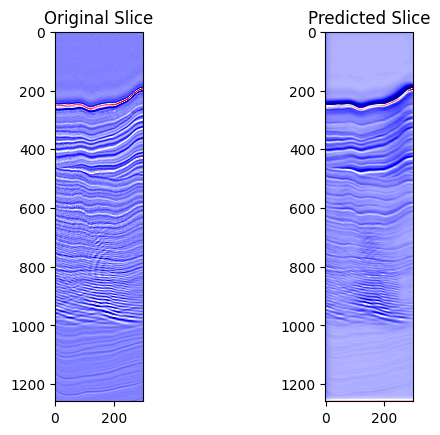

Epoch [1/200], Train Loss: 3959.4047, Train SSIM: 0.6767,           Val Loss: 36605.3543, Val SSIM: -0.0001


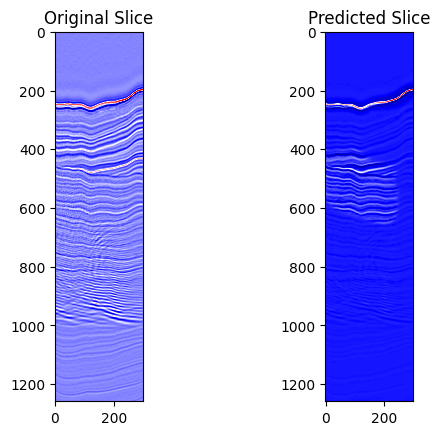

Epoch [2/200], Train Loss: 972.9272, Train SSIM: 0.8291,           Val Loss: 4648.3627, Val SSIM: 0.2753


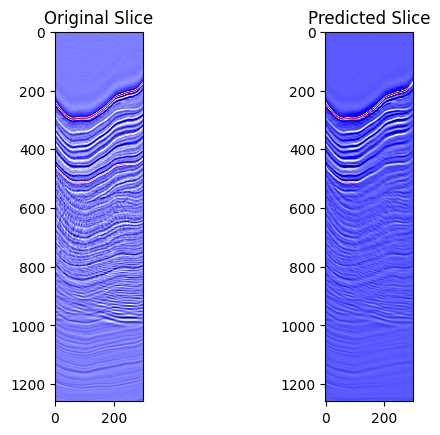

Epoch [3/200], Train Loss: 535.1291, Train SSIM: 0.8634,           Val Loss: 1437.7289, Val SSIM: 0.8143


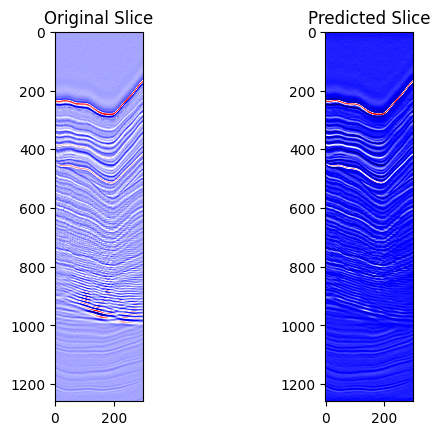

Epoch [4/200], Train Loss: 443.6318, Train SSIM: 0.8821,           Val Loss: 1995.0996, Val SSIM: 0.5444


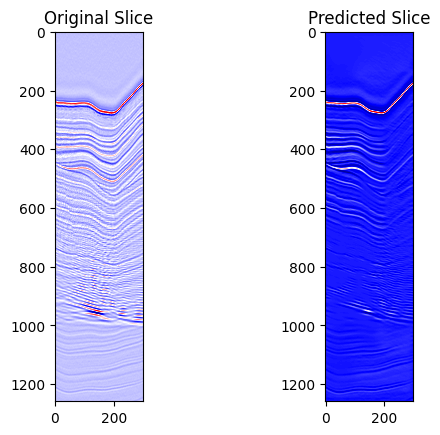

Epoch [5/200], Train Loss: 391.5520, Train SSIM: 0.8927,           Val Loss: 1470.9644, Val SSIM: 0.6272


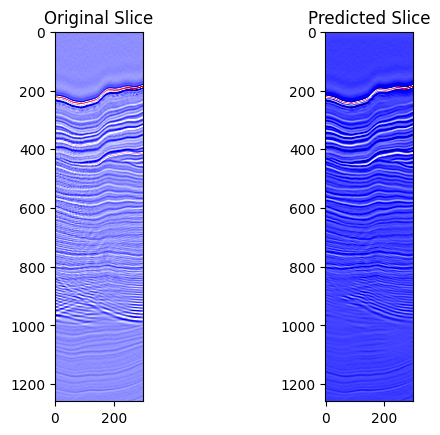

Epoch [6/200], Train Loss: 321.5513, Train SSIM: 0.9071,           Val Loss: 1237.0067, Val SSIM: 0.8198


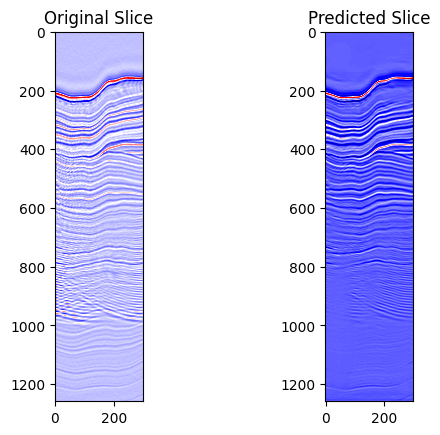

Epoch [7/200], Train Loss: 276.9756, Train SSIM: 0.9166,           Val Loss: 1350.6825, Val SSIM: 0.7206


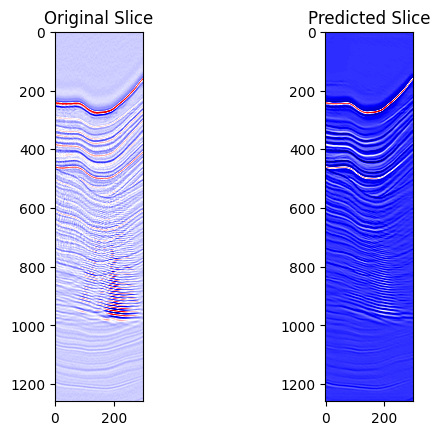

Epoch [8/200], Train Loss: 237.2173, Train SSIM: 0.9263,           Val Loss: 1384.7586, Val SSIM: 0.7273


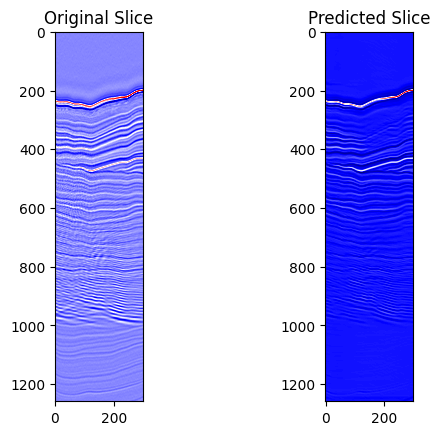

Epoch [9/200], Train Loss: 209.3864, Train SSIM: 0.9344,           Val Loss: 1187.1487, Val SSIM: 0.7683


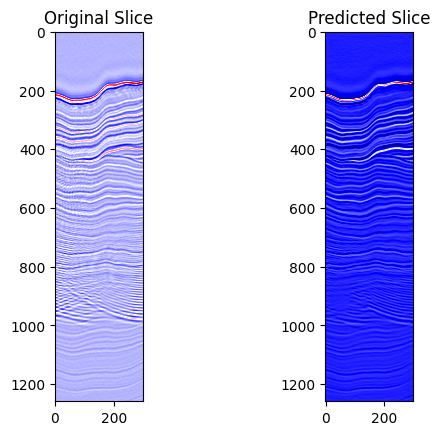

Epoch [10/200], Train Loss: 172.0035, Train SSIM: 0.9445,           Val Loss: 1245.0980, Val SSIM: 0.7833


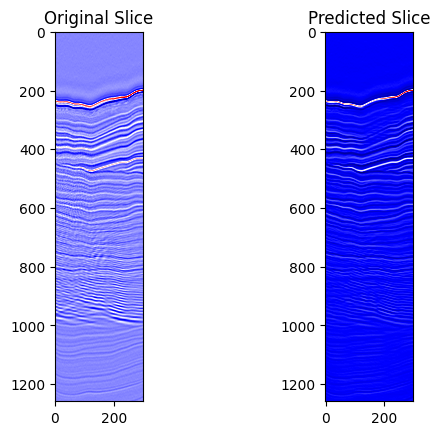

Epoch [11/200], Train Loss: 158.7654, Train SSIM: 0.9499,           Val Loss: 1063.9864, Val SSIM: 0.8715


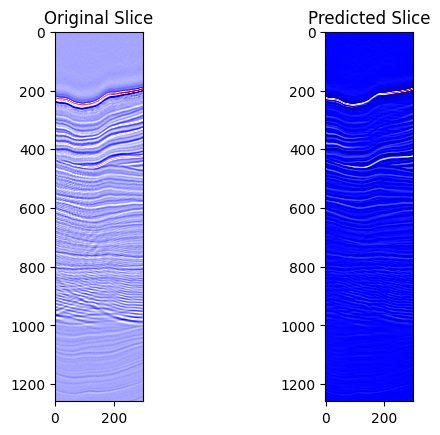

Epoch [12/200], Train Loss: 137.0847, Train SSIM: 0.9565,           Val Loss: 1103.5823, Val SSIM: 0.8817


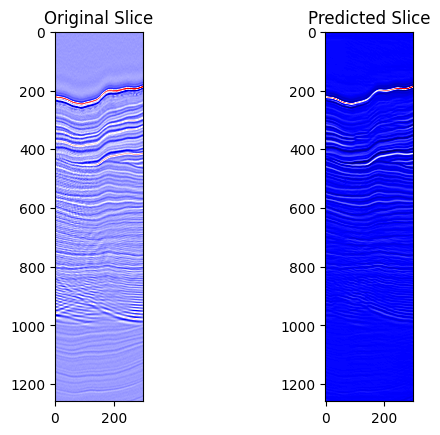

Epoch [13/200], Train Loss: 122.2481, Train SSIM: 0.9610,           Val Loss: 1204.3518, Val SSIM: 0.8580


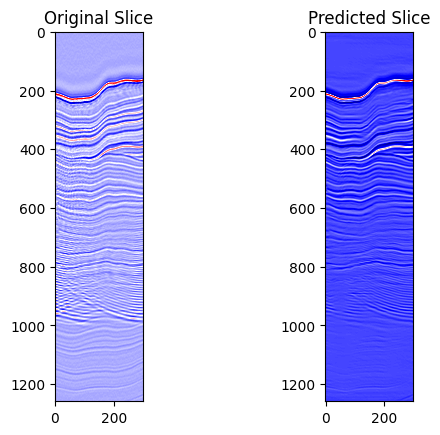

Epoch [14/200], Train Loss: 109.9996, Train SSIM: 0.9653,           Val Loss: 1223.6630, Val SSIM: 0.8246


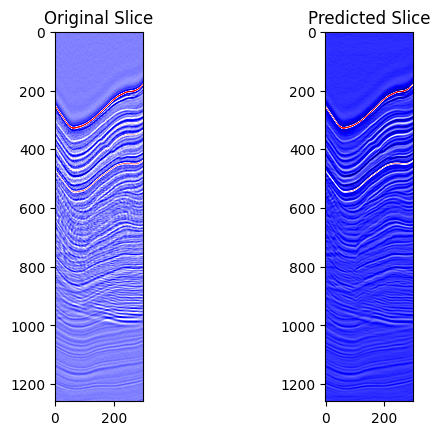

Epoch [15/200], Train Loss: 106.4052, Train SSIM: 0.9667,           Val Loss: 1115.0465, Val SSIM: 0.8653


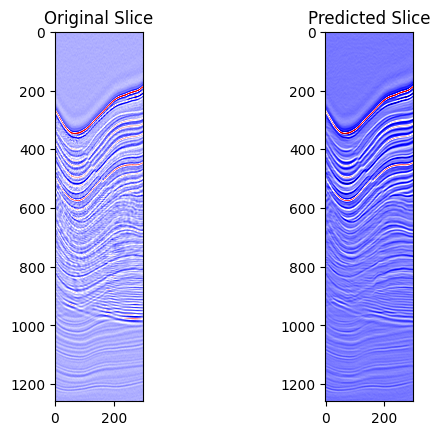

Epoch [16/200], Train Loss: 94.7223, Train SSIM: 0.9702,           Val Loss: 1368.3110, Val SSIM: 0.7991


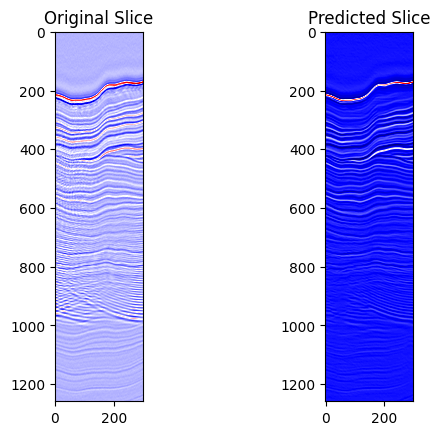

Epoch [17/200], Train Loss: 85.8651, Train SSIM: 0.9735,           Val Loss: 1185.0150, Val SSIM: 0.8593


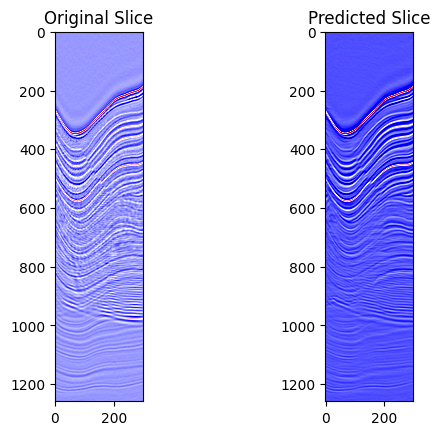

Epoch [18/200], Train Loss: 78.5208, Train SSIM: 0.9759,           Val Loss: 1293.8965, Val SSIM: 0.8436


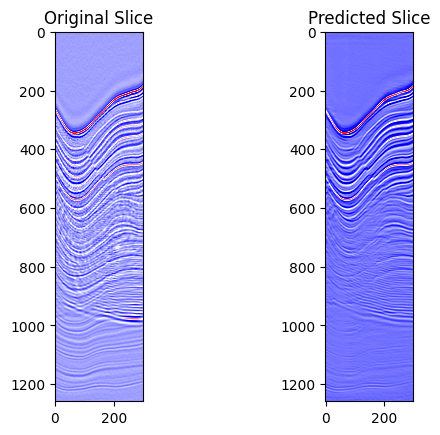

Epoch [19/200], Train Loss: 73.6960, Train SSIM: 0.9781,           Val Loss: 1140.7677, Val SSIM: 0.8619


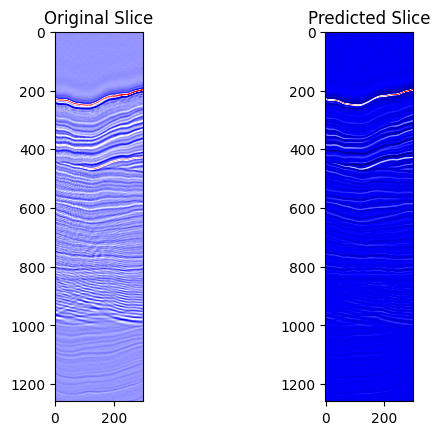

Epoch [20/200], Train Loss: 73.2345, Train SSIM: 0.9787,           Val Loss: 1266.5717, Val SSIM: 0.8570


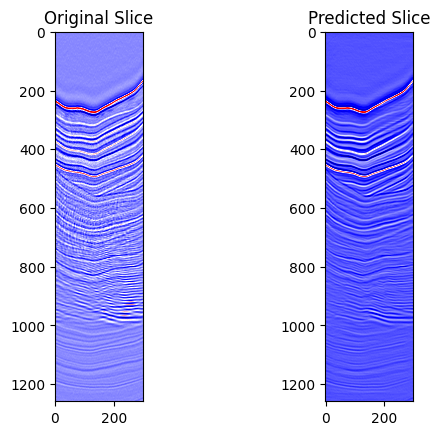

Epoch [21/200], Train Loss: 73.0801, Train SSIM: 0.9786,           Val Loss: 1185.0675, Val SSIM: 0.8630


In [ ]:
# Number of epochs
num_epochs = 200

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_ssim = 0.0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_ssim = ssim_metric(outputs.detach(), y_batch.detach())
        running_ssim += batch_ssim.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_ssim = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            val_outputs = model(x_val)
            val_loss += criterion(val_outputs, y_val).item()
            val_ssim += ssim_metric(val_outputs, y_val).item()

    # Prediction on a single slice from X_slices_t
    random_slice = X_slices_t[torch.randint(0, len(X_slices_t), (1,)).item()]

    # Convert to PyTorch tensor and add batch and channel dimensions
    random_slice = torch.tensor(random_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    prediction = model(random_slice).detach()

    # Visualize the original and predicted slice
    plt.subplot(1, 2, 1)
    plt.title("Original Slice")
    plt.imshow(random_slice.squeeze().cpu().numpy(), cmap='seismic')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Slice")
    plt.imshow(prediction.squeeze().cpu().numpy(), cmap='seismic')
    plt.show()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train SSIM: {running_ssim / len(train_loader):.4f}, \
          Val Loss: {val_loss / len(val_loader):.4f}, Val SSIM: {val_ssim / len(val_loader):.4f}")


print("Training complete!")
